# SVM on DonorChoose Data set

# Readding Data from Kaggle Cloud

In [1]:
#!pip install -q kaggle

In [2]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

In [3]:
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#!~/.local/bin/kaggle datasets download -d palakurthidurga/glovedataset

In [5]:
#!unzip glovedataset

In [6]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

# DonorsChoose
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

* How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
* How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
* How to focus volunteer time on the applications that need the most assistance.

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


# 1.0. Reading Data

## 1.1.Removing warnings 

In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## 1.2. Reading Existing Folders

In [8]:
import os
os.listdir()

['.bash_logout',
 '.bashrc',
 '.profile',
 'glove_vectors',
 'resources.csv',
 '.cache',
 'glove.42B.300d.txt',
 '.jupyter',
 'Untitled.ipynb',
 '.python_history',
 'LogisticRegression.ipynb',
 'SVMDNC.ipynb',
 '.ipynb_checkpoints',
 'command.txt',
 'glovedataset.zip',
 'Untitled1.ipynb',
 'Donor_Choose_K_NN_.ipynb',
 'kaggle.json',
 '.viminfo',
 '.local',
 '.cufflinks',
 '.kaggle',
 '.bash_history',
 'nohup.out',
 '.keras',
 '.config',
 'Donor_Choose_NB.ipynb',
 'Logistic_Regression.ipynb',
 'server.sh',
 'nltk_data',
 'train_data.csv',
 '.ipython',
 '.ssh']

In [9]:
import numpy as np
import pandas as pd

## 1.3.Reading Existing Data

In [10]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [11]:
print("Number of data points in train data", project_data.shape)
print('*'*50)
print('Number of resource points related to train data', resource_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
**************************************************
Number of resource points related to train data (1541272, 4)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


> **Number of resourse points are higher which means either each project has multiple data points in resource file or some of the project points are missing.**

## 1.4. Replace Project Date column name

In [12]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
# get all column names as list and replace project_submitted_datetime with Date
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
# this will reorder the column name based on the our requirement
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


## 2. Preprocessing Data

## 2.1. Preprocessing of porject_subject_category

> Each category contains multiple labels of strings like Math&Science literature.The ampersand tells two words form single word and we need to preserve that, by making Math_Science as one word and literature as one word. We also need to remove words like The, which does not really tell anything to us.

In [13]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

# sort dictionary values https://stackoverflow.com/a/613218
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

## 2.2.Preprocessing of project_subject_subcategories
> Each category contains multiple labels of strings like Math&Science literature.The ampersand tells two words form single word and we need to preserve that, by making Math_Science as one word and literature as one word. We also need to remove words like The, which does not really tell anything to us.

> We will take each unique string and number of times it is repeating into a dictinary and later point used to generate onehotencoded/Binary BOW vectors

In [14]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 2.3.Preprocessing teacher-prefix data

In [15]:
#remove rows with nan values 
#https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-certain-columns-is-nan
import re
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('nan')
my_counter = Counter()
prefixes = []
for word in project_data['teacher_prefix'].values:
    word = re.sub('[^A-Za-z0-9]+', '', word)
    prefixes.append(word)
    my_counter.update(word.split())
teacher_prefix_dict = dict(my_counter)
teacher_prefix_cat_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))
print(teacher_prefix_cat_dict)
teacher_prefix_cat_dict.pop('nan', None)

{'Dr': 13, 'nan': 3, 'Teacher': 2360, 'Mr': 10648, 'Ms': 38955, 'Mrs': 57269}


3

## 2.4.Preprocessing School state data

In [16]:
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())
school_state_dict = dict(my_counter)
school_state_cat_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))
print(school_state_cat_dict)

{'WV': 503, 'NJ': 2237, 'IL': 4350, 'DC': 516, 'AL': 1762, 'HI': 507, 'MI': 3161, 'MT': 245, 'MN': 1208, 'AZ': 2147, 'KS': 634, 'FL': 6185, 'AK': 345, 'NH': 348, 'NY': 7318, 'VT': 80, 'UT': 1731, 'SD': 300, 'VA': 2045, 'ND': 143, 'GA': 3963, 'DE': 343, 'SC': 3936, 'CA': 15388, 'CO': 1111, 'TX': 7396, 'RI': 285, 'CT': 1663, 'WA': 2334, 'IA': 666, 'NV': 1367, 'LA': 2394, 'ID': 693, 'MA': 2389, 'NM': 557, 'MS': 1323, 'WY': 98, 'AR': 1049, 'ME': 505, 'OH': 2467, 'PA': 3109, 'OK': 2276, 'WI': 1827, 'NE': 309, 'MO': 2576, 'OR': 1242, 'IN': 2620, 'TN': 1688, 'NC': 5091, 'KY': 1304, 'MD': 1514}


## 2.5.Preprocessing of Project Grade Cateory Data

In [17]:
my_counter = Counter()

#we will replace given categorical values with our own so that it is easy to preprocess
"""
h: for grades 9-12
lh: Grades 6-8
up: for Grades 3-5
p: Grades Prek-2
"""

project_data['project_grade_category'].replace(
    to_replace=['Grades 9-12', 'Grades 6-8', 'Grades 3-5', 'Grades PreK-2'],
    value=['h', 'lh', 'up', 'p'],
    inplace=True
)
for word in project_data['project_grade_category'].values:
    my_counter.update(word.split())
project_grade_category_dict = dict(my_counter)
project_grade_category_cat_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))
project_grade_category_cat_dict.pop('Grades', None)
print(project_grade_category_cat_dict)

{'up': 37137, 'h': 10963, 'p': 44225, 'lh': 16923}


# 2.6. Preprocessing of essays

### 2.6.1.Merging all essays

> As mention in the documentation of problem statement, before 2016 there submitter must have write 4 essays but now they only need to write 2. Either way the essays describe how the project is going to help students.

In [18]:
# merge two column text dataframe: 
#https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

### 2.6.2.Drop `project_essay_1` `project_essay_2` `project_essay_3` `project_essay_4`

In [19]:
#  delete #project_essay_1,2,3,4
project_data.drop(["project_essay_1", "project_essay_2",  "project_essay_3", "project_essay_4"], inplace= True, axis = 1) 
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,p,Engineering STEAM into the Primary Classroom,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,I have been fortunate enough to use the Fairy ...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,up,Sensory Tools for Focus,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,Imagine being 8-9 years old. You're in your th...


### 2.6.3.Read some random essay

In [20]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

> Essays have characters like \r\n\t etc which are useless for our analyssis. . Along with special characters it also contains some special charecters

### 2.6.4.Extend short forms

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) #kiran's = kiran has; it's  = it is
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

\"A person is a person, no matter how small.\" (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed. \r\nStudents in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.\r\nOur school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the ear

### 2.6.5. Remove Special Characters

In [23]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 A person is a person, no matter how small.  (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed.   Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.  Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the early chi

In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 A person is a person no matter how small Dr Seuss I teach the smallest students with the biggest enthusiasm for learning My students learn in many different ways using all of our senses and multiple intelligences I use a wide range of techniques to help all my students succeed Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures including Native Americans Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom Kindergarteners in my class love to work with hands on materials and have many different opportunities to practice a skill before it is mastered Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum Montana is the perfect place to learn about agriculture and nutrition My students love to role play in our pretend kitchen in the early childhood classroom

In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", 'nannan']

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:09<00:00, 1575.91it/s]


In [27]:
# after preprocesing
preprocessed_essays[20000]
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(["essay"], inplace= True, axis = 1) 
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essays
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,p,Engineering STEAM into the Primary Classroom,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,up,Sensory Tools for Focus,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...


## 2.7.Preprocessing of titles

In [28]:
# printing some random reviews
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[5000])
print("="*50)
print(project_data['project_title'].values[10000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[30000])
print("="*50)
print(project_data['project_title'].values[40000])
print("="*50)
print(project_data['project_title'].values[50000])
print("="*50)
print(project_data['project_title'].values[70000])
print("="*50)
print(project_data['project_title'].values[99999])
print("="*50)

Engineering STEAM into the Primary Classroom
Building Blocks for Learning
Empowering Students Through Art:Learning About Then and Now
Mark my time bookmarks
Alternative Seating: Making Learning More Comfy!
Health Nutritional Cooking in Kindergarten
Wiggly Without Consequences
Gear for Great Kids!
Tracking Our Fitness in 4th Grade
Place Hands on Learning... in the Hands of Little Learners!
Turning to Flexible Seating: One Sixth-Grade Class's Journey to Freedom


In [29]:
sent = decontracted(project_data['project_title'].values[99999])
print(sent)
print("="*50)

Turning to Flexible Seating: One Sixth-Grade Class is Journey to Freedom


In [30]:
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

Turning to Flexible Seating One Sixth Grade Class is Journey to Freedom


In [31]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 36159.72it/s]


In [32]:
# after preprocesing
project_data['preprocessed_titles'] = preprocessed_titles
#project_data.drop(["essay"], inplace= True, axis = 1) 
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essays,preprocessed_titles
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,p,Engineering STEAM into the Primary Classroom,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,up,Sensory Tools for Focus,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...,sensory tools focus


## 2.8. Introducing New Features

### 2.8.1. Title word Count

In [33]:
title_word_count = []
for a in project_data['preprocessed_titles'] :
    b = len(a.split())
    title_word_count.append(b)

project_data['title_word_count'] = title_word_count
print(title_word_count[:10])

[4, 3, 5, 4, 5, 4, 6, 4, 2, 5]


### 2.8.2. Essays Word Count

In [34]:
essay_word_count = []
for a in project_data['preprocessed_essays'] :
    b = len(a.split())
    essay_word_count.append(b)

project_data['essay_word_count'] = essay_word_count
print(project_data['essay_word_count'][:10])

55660    156
76127    159
51140    106
473      114
41558    101
29891    147
81565    160
79026    259
23374    178
86551    157
Name: essay_word_count, dtype: int64


# 3.Splitting data into Train and cross validation(or test): Stratified Sampling

In [35]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
# this step will ignore resource description column
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [36]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essays,preprocessed_titles,title_word_count,essay_word_count,quantity,price
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,p,Engineering STEAM into the Primary Classroom,My students need STEM kits to learn critical s...,53,1,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,4,156,4,725.05
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,up,Sensory Tools for Focus,My students need Boogie Boards for quiet senso...,4,1,SpecialNeeds,SpecialNeeds,imagine 8 9 years old third grade classroom se...,sensory tools focus,3,159,8,213.03


In [37]:
project_data.shape

(109248, 19)

> splitting given data into train and test with 80% in train and 20% in test

In [38]:
#what is stratified sampling: https://explorable.com/stratified-sampling
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

project_data_train, project_data_test, project_data_labels_train, project_data_labels_test = train_test_split(project_data, project_data['project_is_approved'], stratify=project_data['project_is_approved'],test_size=0.2)
print(project_data_train.shape)
print(project_data_labels_train.shape)

(87398, 19)
(87398,)


# 4.Make Data Model Ready:

we are going to consider

   - school_state : `categorical data`
   - clean_categories : `categorical data`
   - clean_subcategories : `categorical data`
   - project_grade_category : `categorical data`
   - teacher_prefix : `categorical data`


   - project_title : `text data`
   - text : `text data`



   - quantity : `numerical` (optional)
   - teacher_number_of_previously_posted_projects : `numerical`
   - price : `numerical`

## 4.1.Encoding Numerical and Categorical features

#https://stackoverflow.com/questions/31572487/fitting-data-vs-transforming-data-in-scikit-learn

**Fit method:** fitting data is to to find the internal parameter of model that will be used in transforming data

**Transform Method:** returns the encoded data on fitted vectorizer object

**fit_transform Method:** combination of fit and transform method

### 4.1.1.Vectorizing categorical data `school-state`

**On train dataset**

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(school_state_cat_dict.keys()), lowercase=False, binary=True)

vectorizer.fit(project_data_train['school_state'].values)

school_state_one_hot = vectorizer.transform(project_data_train['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['WV', 'NJ', 'IL', 'DC', 'AL', 'HI', 'MI', 'MT', 'MN', 'AZ', 'KS', 'FL', 'AK', 'NH', 'NY', 'VT', 'UT', 'SD', 'VA', 'ND', 'GA', 'DE', 'SC', 'CA', 'CO', 'TX', 'RI', 'CT', 'WA', 'IA', 'NV', 'LA', 'ID', 'MA', 'NM', 'MS', 'WY', 'AR', 'ME', 'OH', 'PA', 'OK', 'WI', 'NE', 'MO', 'OR', 'IN', 'TN', 'NC', 'KY', 'MD']
Shape of matrix after one hot encodig  (87398, 51)


**On test dataset**

In [40]:

school_state_one_hot_test = vectorizer.transform(project_data_test['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",school_state_one_hot_test.shape)

['WV', 'NJ', 'IL', 'DC', 'AL', 'HI', 'MI', 'MT', 'MN', 'AZ', 'KS', 'FL', 'AK', 'NH', 'NY', 'VT', 'UT', 'SD', 'VA', 'ND', 'GA', 'DE', 'SC', 'CA', 'CO', 'TX', 'RI', 'CT', 'WA', 'IA', 'NV', 'LA', 'ID', 'MA', 'NM', 'MS', 'WY', 'AR', 'ME', 'OH', 'PA', 'OK', 'WI', 'NE', 'MO', 'OR', 'IN', 'TN', 'NC', 'KY', 'MD']
Shape of matrix after one hot encodig  (21850, 51)


### 4.1.2.Vectorizing categorical data `project-grade-category`

**On Train dataset**

In [41]:
vectorizer = CountVectorizer(vocabulary=list(project_grade_category_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_train['project_grade_category'].values)
project_grade_category_one_hot = vectorizer.transform(project_data_train['project_grade_category'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)

['up', 'h', 'p', 'lh']
Shape of matrix after one hot encodig  (87398, 4)


**On test dataset**

In [42]:
project_grade_category_one_hot_test = vectorizer.transform(project_data_test['project_grade_category'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot_test.shape)

['up', 'h', 'p', 'lh']
Shape of matrix after one hot encodig  (21850, 4)


### 4.1.3.Vectorizing categorical data `teacher-prefix`

**On train dataset**

In [43]:
vectorizer = CountVectorizer(vocabulary=list(teacher_prefix_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_train['teacher_prefix'].values)
print(vectorizer.get_feature_names())

teacher_prefix_categories_one_hot = vectorizer.transform(project_data_train['teacher_prefix'].values)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot.shape)

['Dr', 'Teacher', 'Mr', 'Ms', 'Mrs']
Shape of matrix after one hot encoding  (87398, 5)


**On test dataset**

In [44]:

teacher_prefix_categories_one_hot_test = vectorizer.transform(project_data_test['teacher_prefix'].values)
print("Shape of matrix after one hot encoding ",teacher_prefix_categories_one_hot_test.shape)

Shape of matrix after one hot encoding  (21850, 5)


### 4.1.4.Vectorizing categorical data `clean-categories`

**On train dataset**

In [45]:
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_train['clean_categories'].values)
clean_category_one_hot = vectorizer.transform(project_data_train['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",clean_category_one_hot.shape)

['Music_Arts', 'Math_Science', 'Literacy_Language', 'SpecialNeeds', 'Health_Sports', 'Warmth', 'History_Civics', 'Care_Hunger', 'AppliedLearning']
Shape of matrix after one hot encodig  (87398, 9)


**On test  dataset**

In [46]:

clean_category_one_hot_test = vectorizer.transform(project_data_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",clean_category_one_hot_test.shape)

['Music_Arts', 'Math_Science', 'Literacy_Language', 'SpecialNeeds', 'Health_Sports', 'Warmth', 'History_Civics', 'Care_Hunger', 'AppliedLearning']
Shape of matrix after one hot encodig  (21850, 9)


### 4.1.5. Vectorizing categorical data `clean_subcategories`

**On train dataset**

In [47]:
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data_train['clean_subcategories'].values)
clean_sub_category_one_hot = vectorizer.transform(project_data_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",clean_sub_category_one_hot.shape)

['History_Geography', 'Economics', 'SocialSciences', 'NutritionEducation', 'Warmth', 'ParentInvolvement', 'Music', 'PerformingArts', 'TeamSports', 'Other', 'Gym_Fitness', 'Health_LifeScience', 'Mathematics', 'FinancialLiteracy', 'CommunityService', 'Care_Hunger', 'CharacterEducation', 'Literacy', 'ESL', 'SpecialNeeds', 'College_CareerPrep', 'VisualArts', 'AppliedSciences', 'EnvironmentalScience', 'EarlyDevelopment', 'ForeignLanguages', 'Civics_Government', 'Literature_Writing', 'Extracurricular', 'Health_Wellness']
Shape of matrix after one hot encodig  (87398, 30)


**On test dataset**

In [48]:
clean_sub_category_one_hot_test = vectorizer.transform(project_data_test['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",clean_sub_category_one_hot_test.shape)

['History_Geography', 'Economics', 'SocialSciences', 'NutritionEducation', 'Warmth', 'ParentInvolvement', 'Music', 'PerformingArts', 'TeamSports', 'Other', 'Gym_Fitness', 'Health_LifeScience', 'Mathematics', 'FinancialLiteracy', 'CommunityService', 'Care_Hunger', 'CharacterEducation', 'Literacy', 'ESL', 'SpecialNeeds', 'College_CareerPrep', 'VisualArts', 'AppliedSciences', 'EnvironmentalScience', 'EarlyDevelopment', 'ForeignLanguages', 'Civics_Government', 'Literature_Writing', 'Extracurricular', 'Health_Wellness']
Shape of matrix after one hot encodig  (21850, 30)


### 4.1.6. Vectorizing Numerical data `Price`

**On train dataset**

In [49]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print("Mean : {}".format(price_scalar.mean_[0]))
print("Standard deviation : {}".format(np.sqrt(price_scalar.var_[0])))
# Now standardize the data with above mean and variance.
price_standardized = price_scalar.transform(project_data_train['price'].values.reshape(-1, 1))
print(price_standardized.shape)

Mean : 297.7294599418751
Standard deviation : 366.8190821163493
(87398, 1)


In [50]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(project_data_train['price'].values.reshape(1, -1)) 
price_standardized = transformer.transform(project_data_train['price'].values.reshape(1, -1))
print(price_standardized.shape)

(1, 87398)


**On test dataset**

In [51]:
price_standardized_test = transformer.transform(project_data_test['price'].values.reshape(1, -1))
print(price_standardized_test.shape)

(1, 21850)


### 4.1.7.Vectorizing numerical data `Quantity`

**On Train dataset**

In [52]:
transformer = Normalizer().fit(project_data_train['quantity'].values.reshape(1, -1))
quantity_standardized = transformer.transform(project_data_train['quantity'].values.reshape(1, -1))
print(quantity_standardized.shape)

(1, 87398)


**On test dataset**

In [53]:
quantity_standardized_test = transformer.transform(project_data_test['quantity'].values.reshape(1, -1))
print(quantity_standardized_test.shape)

(1, 21850)


### 4.1.8.Vectorizing numerical data `teacher_numeber_of_previously_posted_projects`

**On train dataset**

In [54]:
transformer = Normalizer().fit(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
prev_projects_standardized = transformer.transform(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
print(prev_projects_standardized.shape)

(1, 87398)


**On test dataset**

In [55]:
prev_projects_standardized_test = transformer.transform(project_data_test['teacher_number_of_previously_posted_projects'].values.reshape(1, -1))
print(prev_projects_standardized_test.shape)

(1, 21850)


### 4.1.9. Vectorizing Title Word Count

**On Train Data**

In [56]:
transformer = Normalizer().fit(project_data_train['title_word_count'].values.reshape(1, -1))  # fit does nothing.
title_word_count_normalized = transformer.transform(project_data_train['title_word_count'].values.reshape(1, -1))
print(title_word_count_normalized.shape)

(1, 87398)


**On Test Data**

In [57]:
title_word_count_normalized_test = transformer.transform(project_data_test['title_word_count'].values.reshape(1, -1))
print(title_word_count_normalized_test.shape)

(1, 21850)


### 4.1.10. Vectorizing Essay Word Count

**On Train Data**

In [58]:
transformer = Normalizer().fit(project_data_train['essay_word_count'].values.reshape(1, -1))  # fit does nothing.
essay_word_count_normalized = transformer.transform(project_data_train['essay_word_count'].values.reshape(1, -1))
print(essay_word_count_normalized.shape)

(1, 87398)


**On Test Data**

In [59]:
essay_word_count_normalized_test = transformer.transform(project_data_test['essay_word_count'].values.reshape(1, -1))
print(essay_word_count_normalized_test.shape)
print(essay_word_count_normalized_test[:10])

(1, 21850)
[[0.00543572 0.00762909 0.00700922 ... 0.00529268 0.00696154 0.00429136]]


## 4.2.Encoding text features

### 4.2.1.Vectorizing text feature `project-essays`

#### 4.2.1.1. BOW `preprocessed_essays`

**On train data**

In [60]:
# we are considering only the words which appeared  in at least 10 documents
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(project_data_train['preprocessed_essays'])
train_essay_bow = vectorizer.transform(project_data_train['preprocessed_essays'])
print("Shape of matrix after BOW essays:",train_essay_bow.shape)

Shape of matrix after BOW essays: (87398, 15128)


**On Test data**

In [61]:
test_essay_bow = vectorizer.transform(project_data_test['preprocessed_essays'])
print("Shape of matrix after BOW essays:",test_essay_bow.shape)

Shape of matrix after BOW essays: (21850, 15128)


#### 4.2.1.1. BOW `preprocessed_essays` bi grams

In [62]:
# we are considering only the words which appeared  in at least 10 documents
vectorizer = CountVectorizer(min_df=10, ngram_range=(2,2), max_features=5000)
vectorizer.fit(project_data_train['preprocessed_essays'])
train_essay_bow_bi = vectorizer.transform(project_data_train['preprocessed_essays'])
print("Shape of matrix after BOW essays:",train_essay_bow_bi.shape)

Shape of matrix after BOW essays: (87398, 5000)


#### on Test Data

In [63]:
test_essay_bow_bi = vectorizer.transform(project_data_test['preprocessed_essays'])
print("Shape of matrix after BOW essays:",test_essay_bow_bi.shape)

Shape of matrix after BOW essays: (21850, 5000)


#### 4.2.1.2. TFIDF vectorizer `essays`

**On Train data**

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(project_data_train['preprocessed_essays'])
train_tfidf_essays = vectorizer.transform(project_data_train['preprocessed_essays'])
print("Shape of matrix after TFIDF train data essays:",train_tfidf_essays.shape)

Shape of matrix after TFIDF train data essays: (87398, 15128)


**On Test data**

In [65]:
test_tfidf_essays = vectorizer.transform(project_data_test['preprocessed_essays'])
print("Shape of matrix after TFIDF train data essays:",test_tfidf_essays.shape)

Shape of matrix after TFIDF train data essays: (21850, 15128)


#### TFIDF vectorizer `essays` bigrams

In [66]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(2,2), max_features=5000)
vectorizer.fit(project_data_train['preprocessed_essays'])
train_tfidf_essays_bi = vectorizer.transform(project_data_train['preprocessed_essays'])
print("Shape of matrix after TFIDF train data essays:",train_tfidf_essays_bi.shape)

Shape of matrix after TFIDF train data essays: (87398, 5000)


#### On test data

In [67]:
test_tfidf_essays_bi = vectorizer.transform(project_data_test['preprocessed_essays'])
print("Shape of matrix after TFIDF train data essays:",test_tfidf_essays_bi.shape)

Shape of matrix after TFIDF train data essays: (21850, 5000)


#### 4.2.1.3.AVG W2V[] `essays`

**Loading Glove Vectors**

In [68]:
#!unzip glovedataset

In [69]:
#http://yaronvazana.com/2018/09/20/average-word-vectors-generate-document-paragraph-sentence-embeddings/
## Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
from tqdm import tqdm
import numpy as np
import pandas as pd
def loadGloveModel(gloveFile):
    print('loading Glove Model')
    f = open(gloveFile, 'r', encoding='utf-8')
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.", len(model), "word loaded!")
    f.close()
    return model
model = loadGloveModel('glove.42B.300d.txt')

946it [00:00, 9451.63it/s]

loading Glove Model


1917495it [03:29, 9147.97it/s]

Done. 1917495 word loaded!


**Getting all Uniqe words from `essays` and `titles` on train dataset**

In [70]:
words = []
for i in project_data_train['preprocessed_essays']:
    words.extend(i.split(' '))
for i in project_data_train['preprocessed_titles']:
    words.extend(i.split(' '))
print("all the words in the corpus", len(words))
words = set(words)
print("the unique words in the corpus", len(words))

all the words in the corpus 12313188
the unique words in the corpus 53775


**Getting all Unitqe words from `essays` and `titles` on test dataset**

In [71]:
words_test = []
for i in project_data_test['preprocessed_essays']:
    words_test.extend(i.split(' '))
for i in project_data_test['preprocessed_titles']:
    words_test.extend(i.split(' '))
print("all the words in the corpus", len(words_test))
words_test = set(words_test)
print("the unique words in the corpus", len(words_test))

all the words in the corpus 3077775
the unique words in the corpus 31172


**Words present in both `train` dataset and glove words**

In [72]:
inter_words_train = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words_train),"(",np.round(len(inter_words_train)/len(words)*100,3),"%)")

The number of words that are present in both glove vectors and our coupus 47645 ( 88.601 %)


**Words present in both `test` dataset and glove words**

In [73]:
inter_words_test = set(model.keys()).intersection(words_test)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words_test),"(",np.round(len(inter_words_test)/len(words_test)*100,3),"%)")

The number of words that are present in both glove vectors and our coupus 29275 ( 93.914 %)


**Creating word to vec dictionary for each available word in train dataset**

In [74]:
words_courpus_train = {}
#words_glove = set(model.keys())
for i in inter_words_train:
    words_courpus_train[i] = model[i]
print("word 2 vec length", len(words_courpus_train))

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus_train, f)

word 2 vec length 47645


**Creating word to vec dictionary for each available word in test dataset**

In [75]:
words_courpus_test = {}
for i in inter_words_test:
    words_courpus_test[i] = model[i]
print("word 2 vec length", len(words_courpus_test))

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus_test, f)

word 2 vec length 29275


**Average word to Vector  to `essays` train dataset**

In [76]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in inter_words_train:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|██████████| 87398/87398 [00:23<00:00, 3644.04it/s]

87398
300


**Average word to Vector  to `essays` train dataset**

In [77]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        #we look for words which are common to both test and train data
        if word in inter_words_train:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|██████████| 21850/21850 [00:06<00:00, 3621.65it/s]

21850
300


#### 4.2.1.4. TFIDF AVG W2V[] `essays`

**On train dataset**

In [78]:
tfidf_model_essays_train = TfidfVectorizer()
tfidf_model_essays_train.fit(project_data_train['preprocessed_essays'])
dictionary = dict(zip(tfidf_model_essays_train.get_feature_names(), list(tfidf_model_essays_train.idf_)))
tfidf_model_essays_train_words = set(tfidf_model_essays_train.get_feature_names())

In [79]:
tfidf_w2v_vectors_train_essays = []
for sentence in tqdm(project_data_train['preprocessed_essays']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in inter_words_train) and (word in tfidf_model_essays_train_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)#calculating ifidf weighted  w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train_essays.append(vector)
print(len(tfidf_w2v_vectors_train_essays))
print(len(tfidf_w2v_vectors_train_essays[0]))

100%|██████████| 87398/87398 [03:21<00:00, 433.76it/s]

87398
300


**On test dataset**

In [80]:
tfidf_w2v_vectors_test_essays = []
for sentence in tqdm(project_data_test['preprocessed_essays']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in inter_words_train) and (word in tfidf_model_essays_train_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)#calculating ifidf weighted  w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test_essays.append(vector)
print(len(tfidf_w2v_vectors_test_essays))
print(len(tfidf_w2v_vectors_test_essays[0]))

100%|██████████| 21850/21850 [00:49<00:00, 439.08it/s]

21850
300


### 4.2.2. Vectorizing text data `project_titles`

#### 4.2.2.1. BOW `project_titles`

**On Train data**

In [81]:
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(project_data_train['preprocessed_titles'])
train_titles_bow = vectorizer.transform(project_data_train['preprocessed_titles'])
print("Shape of matrix after BOW essays:",train_titles_bow.shape)

Shape of matrix after BOW essays: (87398, 4431)


**On Test data**

In [82]:
test_titles_bow = vectorizer.transform(project_data_test['preprocessed_titles'])
print("Shape of matrix after BOW essays:",test_titles_bow.shape)

Shape of matrix after BOW essays: (21850, 4431)


####  BOW `project_titles` bi grams

**On Train data**

In [83]:
vectorizer = CountVectorizer(min_df=5, ngram_range=(2,2), max_features=5000)
vectorizer.fit(project_data_train['preprocessed_titles'])
train_titles_bow_bi = vectorizer.transform(project_data_train['preprocessed_titles'])
print("Shape of matrix after BOW essays:",train_titles_bow_bi.shape)

Shape of matrix after BOW essays: (87398, 5000)


**On Test Data**

In [84]:
test_titles_bow_bi = vectorizer.transform(project_data_test['preprocessed_titles'])
print("Shape of matrix after BOW essays:",test_titles_bow_bi.shape)

Shape of matrix after BOW essays: (21850, 5000)


#### 4.2.2.2. TFIDF `project_titles`

**On train data**

In [85]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer.fit(project_data_train['preprocessed_titles'])
train_tfidf_titles = vectorizer.transform(project_data_train['preprocessed_titles'])
print("Shape of matrix after TFIDF train data essays:",train_tfidf_titles.shape)

Shape of matrix after TFIDF train data essays: (87398, 4431)


**On test data**

In [86]:
test_tfidf_titles = vectorizer.transform(project_data_test['preprocessed_titles'])
print("Shape of matrix after TFIDF train data essays:",test_tfidf_titles.shape)

Shape of matrix after TFIDF train data essays: (21850, 4431)


#### TFIDF `project_titles` bi grams

**On Train Data**

In [87]:
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(2,2), max_features=5000)
vectorizer.fit(project_data_train['preprocessed_titles'])
train_tfidf_titles_bi = vectorizer.transform(project_data_train['preprocessed_titles'])
print("Shape of matrix after TFIDF train data essays:",train_tfidf_titles.shape)

Shape of matrix after TFIDF train data essays: (87398, 4431)


**On Train Data**

In [88]:
test_tfidf_titles_bi = vectorizer.transform(project_data_test['preprocessed_titles'])
print("Shape of matrix after TFIDF train data essays:",test_tfidf_titles_bi.shape)

Shape of matrix after TFIDF train data essays: (21850, 5000)


#### 4.2.2.3. Average W2V `project_titles`

**On Train dataset**

In [89]:
avg_w2v_vectors_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_train['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in inter_words_train:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_train.append(vector)

print(len(avg_w2v_vectors_titles_train))
print(len(avg_w2v_vectors_titles_train[0]))

100%|██████████| 87398/87398 [00:01<00:00, 65310.08it/s]

87398
300


**On Test Dataset**

In [90]:
avg_w2v_vectors_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(project_data_test['preprocessed_titles']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in inter_words_train:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_test.append(vector)

print(len(avg_w2v_vectors_titles_test))
print(len(avg_w2v_vectors_titles_test[0]))

100%|██████████| 21850/21850 [00:00<00:00, 65175.08it/s]

21850
300


#### 4.2.2.4.Weighted TF-IDF W2V `project_titles`

**On Train Dataset**

In [91]:
tfidf_model_titles_train = TfidfVectorizer()
tfidf_model_titles_train.fit(project_data_train['preprocessed_titles'])
dictionary = dict(zip(tfidf_model_titles_train.get_feature_names(), list(tfidf_model_titles_train.idf_)))
tfidf_model_titles_train_words = set(tfidf_model_titles_train.get_feature_names())

In [92]:
tfidf_w2v_vectors_train_titles = []
for sentence in tqdm(project_data_train['preprocessed_titles']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        if (word in inter_words_train) and (word in tfidf_model_titles_train_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)#calculating ifidf weighted  w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train_titles.append(vector)
print(len(tfidf_w2v_vectors_train_titles))
print(len(tfidf_w2v_vectors_train_titles[0]))

100%|██████████| 87398/87398 [00:03<00:00, 29033.66it/s]

87398
300


**On Test Data**

In [93]:
tfidf_w2v_vectors_test_titles = []
for sentence in tqdm(project_data_test['preprocessed_titles']):
    vector = np.zeros(300)
    tf_idf_weight = 0
    for word in sentence.split():
        #we consider words if only present in both train data and test data
        if (word in inter_words_train) and (word in tfidf_model_titles_train_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)#calculating ifidf weighted  w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test_titles.append(vector)
print(len(tfidf_w2v_vectors_test_titles))
print(len(tfidf_w2v_vectors_test_titles[0]))

100%|██████████| 21850/21850 [00:00<00:00, 26534.75it/s]

21850
300


# 5. Apply Logistic Regression On Dataset

**del model to free RAM**

In [94]:
del model

In [95]:
#!pip install cufflinks

**All Imports**

In [96]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns


**Combining all numerical and categorical features**

>"Combining numerical and categorical data"

In [97]:
#combinnig all the vectors that were asked
#https://stackoverflow.com/questions/22257836/numpy-hstack-valueerror-all-the-input-arrays-must-have-same-number-of-dimens
cat_num = hstack((school_state_one_hot, project_grade_category_one_hot,
                     teacher_prefix_categories_one_hot, clean_category_one_hot,
                    clean_sub_category_one_hot, price_standardized.transpose(), quantity_standardized.transpose(),
                  prev_projects_standardized.transpose(),
                  title_word_count_normalized.transpose() , essay_word_count_normalized.transpose()))

cat_num_test = hstack((school_state_one_hot_test, project_grade_category_one_hot_test,
                     teacher_prefix_categories_one_hot_test, clean_category_one_hot_test, clean_sub_category_one_hot_test,
                       price_standardized_test.transpose(), quantity_standardized_test.transpose(),
                       prev_projects_standardized_test.transpose(), title_word_count_normalized_test.transpose(),
                      essay_word_count_normalized_test.transpose()))

hyperparams = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]#the c value is inverse of the the hyperparm
print(cat_num.shape)
print(cat_num_test.shape)

(87398, 104)
(21850, 104)


In [98]:
print(price_standardized[:10])

[[0.00376314 0.00202573 0.00031117 ... 0.00428151 0.00154115 0.00124531]]


>all the required functions to calculate predictions and KNN

In [99]:

def predict_prob(model, data):
    return model.predict_proba(data)[:,1]


def calAucScore(labels, prob):
    return roc_auc_score(labels,prob)

#returns predictions matrix
def predict(proba, threshoulds, tpr, fpr):
    #the best threshould is at max tpr and min fpr. It should balanace between tpr and fpr
    t = threshoulds[np.argmax(fpr*(1-tpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in tqdm(proba):
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



def getROCValues(pred,labels):
    return roc_curve(labels, pred)



def findCnfMat(labels, predictions):
    return confusion_matrix(labels, predictions)

def drawHeatMap(matrix, x_labels, y_labels):
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(matrix, annot=True, annot_kws={"size": 16}, fmt='g')

**Declaration of all the required variables**

In [100]:
auc_scores_train = []
auc_scores_test = []
MSE = []
accuracy = None
optimal_k = None
train_pred = None
test_pred = None
train_fpr = None
train_tpr = None
tr_thresholds = None
test_fpr = None
test_tpr = None
te_thresholds = None
cnf_matrix_train = None
cnf_matrix_test = None

**Calculation of all the Logistic Regression related variables and predictions in single function**

>we First apply LR and find AUC values for various k values

>Then we apply GridSerchCV to find best hyper parm c = 1 /lambda

>then we find tpr and fpr and draw ROC curve plus confusion matrices

In [101]:
def applyGridsearchCV(params, x_train, y_train):
    model = SGDClassifier(class_weight='balanced')
    tuned_parameters = [{'alpha': params, 'penalty': ['l1', 'l2']}]
    clf = GridSearchCV(model, tuned_parameters, scoring = 'roc_auc', cv=5, return_train_score=True)
    clf.fit(x_train, y_train)
    global train_auc
    global train_auc_std
    global test_auc
    global test_auc_std
    global best_hyper_param
    global best_score
    
    train_auc = clf.cv_results_['mean_train_score']
    train_auc_std = clf.cv_results_['std_train_score']
    test_auc = clf.cv_results_['mean_test_score'] 
    test_auc_std = clf.cv_results_['std_test_score']
    best_hyper_param = clf.best_params_
    best_score = clf.best_score_
    #print(clf.cv_results_)
    print("****grid search cv ended****")
    return best_hyper_param

In [102]:
def drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std):
    plt.figure(figsize=(20,10))
    plt.plot(log_alphas, train_auc[0::2], label='Train AUC-l1')
    #it is typical to draw standard deviation in gridsearch cv
    # this code is taken from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(log_alphas,train_auc[0::2] - train_auc_std[0::2],train_auc[0::2] + train_auc_std[0::2],
                           alpha=0.3,color='darkblue')
    plt.plot(log_alphas, train_auc[1::2], label='Train AUC-l2')
    plt.gca().fill_between(log_alphas,train_auc[1::2] - train_auc_std[1::2],train_auc[1::2] + train_auc_std[1::2],
                           alpha=0.3,color='blue')
    plt.plot(log_alphas, test_auc[0::2], label='TEST AUC-l1')
    # this code is taken from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(log_alphas,test_auc[0::2] - test_auc_std[0::2],test_auc[0::2] + test_auc_std[0::2],
                           alpha=0.3,color='darkorange')
    plt.plot(log_alphas, test_auc[1::2], label='TEST AUC-l2')
    plt.gca().fill_between(log_alphas,test_auc[1::2] - test_auc_std[1::2],test_auc[1::2] + test_auc_std[1::2],
                           alpha=0.3,color='orange')
    plt.scatter(log_alphas, train_auc[0::2], label='Train AUC points-l1')
    plt.scatter(log_alphas, train_auc[1::2], label='Train AUC points-l2')
    plt.scatter(log_alphas,test_auc[0::2], label='TEST AUC points-l1')
    plt.scatter(log_alphas,test_auc[1::2], label='TEST AUC points-l2')


    plt.legend()
    plt.xlabel("alpha: hyperparameter")
    plt.ylabel("AUC")
    plt.title("alpha: hyperparameter v/s AUC")
    plt.grid(linestyle='--')
    plt.show()

In [103]:
def ApplyModel(data_train, labels_train, data_test,labels_test, hyperparams):
    global auc_scores_train
    global auc_scores_test
    global MSE
    global accuracy
    global optimal_k
    global train_pred
    global test_pred
    global train_fpr
    global train_tpr
    global tr_thresholds
    global test_fpr
    global test_tpr
    global te_thresholds
    global cnf_matrix_train
    global cnf_matrix_test
    auc_scores_train = []
    auc_scores_test = []
    MSE = []
    #hyperparams = [1/x if x != 0 else 0 for x in hyperparams]
    print(hyperparams)
    print('\n')
    print('*' * 50)
    print('\n')
    print('applying gridsearch CV to find best hyper parameter')
    
    optimal_hyp = applyGridsearchCV(hyperparams,data_train, labels_train)
    print('optimal hyper param is:', optimal_hyp['alpha'])
    print('best penalty is:', optimal_hyp['penalty'])
    print('\n')
    print('*' * 50)
    print('\n')
    #create optimal model for best alpha nad penalty
    model_optimal = SGDClassifier(class_weight='balanced', alpha = optimal_hyp['alpha'], penalty = optimal_hyp['penalty'])
    model_optimal.fit(data_train, labels_train)
    train_pred = model_optimal.decision_function(data_train)
    test_pred = model_optimal.decision_function(data_test)
    #train_pred = predict_prob(model_optimal, data_train)
    #test_pred = predict_prob(model_optimal, data_test)

    #true positive and false positive values
    train_fpr, train_tpr, tr_thresholds = getROCValues(train_pred,labels_train)
    test_fpr, test_tpr, te_thresholds = getROCValues(test_pred,labels_test)
    
    #print('ROC CURVE for train and test dataset with optimal k value')
    #ROC curves for train and test data sets

    print('*' * 50)
    print('confusion matrix for training data')
    #draw confusion matrix for train data set
    predictions_train = predict(train_pred, tr_thresholds, train_tpr, train_fpr)
    cnf_matrix_train = findCnfMat(labels_train, predictions_train)
    print('confusion matrix', cnf_matrix_train)
    
    print('Heat Map of Confusion of Matrix with training Data')
    #draw heat map on train confusion matrix
    '''drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])'''
    print('*'* 50)

    print('confusion matrix for test data')
    #draw confusion matrix for test data set
    predictions_test = predict(test_pred, te_thresholds, test_tpr, test_fpr)
    cnf_matrix_test = findCnfMat(labels_test, predictions_test)
    print('confusion matrix', cnf_matrix_test)
    
    print('Heat Map of Confusion of Matrix with test Data')
    #draw heat map on test confusion matrix
    '''drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])'''
    print('*' * 50)
    
    return optimal_hyp

In [104]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 5.1.Apply LR on these feature sets
## 5.1.1.categorical, numerical features + project_title(BOW) + project_essays (BOW bigrams)

In [105]:
vectors_train = hstack((cat_num.tocsr(), train_titles_bow.tocsr(), train_essay_bow.tocsr()))
print(vectors_train.shape)
vectors_test = hstack((cat_num_test.tocsr(), test_titles_bow.tocsr(), test_essay_bow.tocsr()))
print(vectors_test.shape)

(87398, 19663)
(21850, 19663)


In [106]:
optimal_hyp = ApplyModel(vectors_train, project_data_labels_train, vectors_test, project_data_labels_test, hyperparams)


[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


**************************************************


applying gridsearch CV to find best hyper parameter
****grid search cv ended****
optimal hyper param is: 0.01
best penalty is: l2


**************************************************




100%|██████████| 21850/21850 [00:00<00:00, 1293898.58it/s]

**************************************************
confusion matrix for training data
the maximum value of tpr*(1-fpr) 0.5114938528703531 for threshold 0.006
confusion matrix [[ 9880  3354]
 [24193 49971]]
Heat Map of Confusion of Matrix with training Data
**************************************************
confusion matrix for test data
the maximum value of tpr*(1-fpr) 0.4614732304202479 for threshold 0.072


confusion matrix [[ 2369   939]
 [ 6950 11592]]
Heat Map of Confusion of Matrix with test Data
**************************************************


#### GridSearch CV AUC vs hyperparams

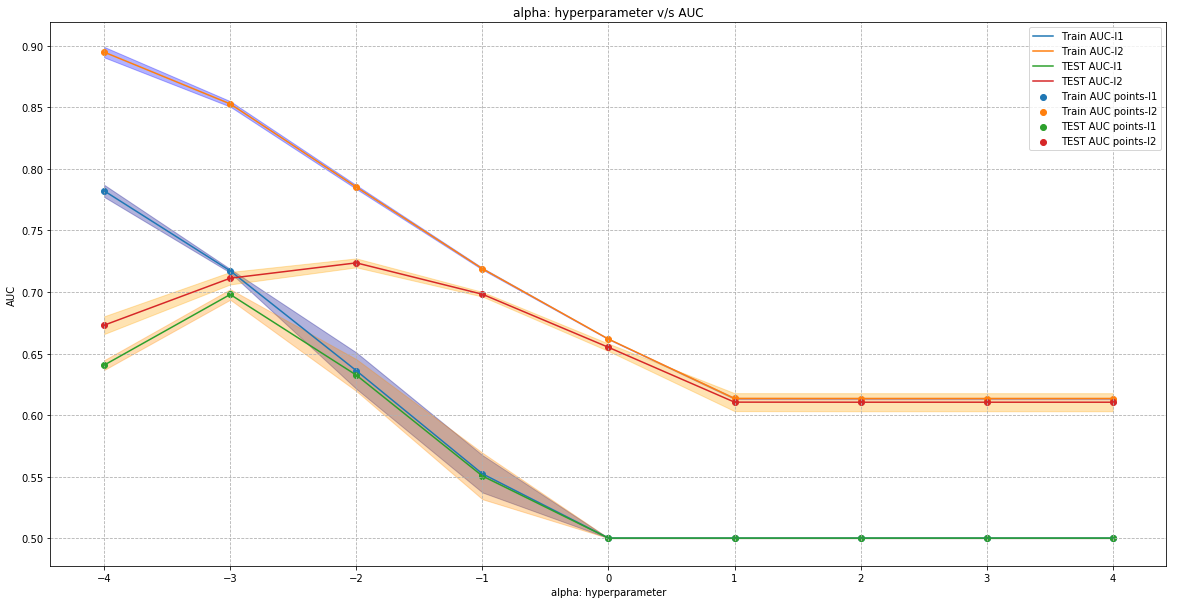

In [107]:
import math
import matplotlib.pyplot as plt


log_alphas = [math.log(x, 10) for x in hyperparams]

#print(train_auc)
drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std)

In [108]:
print('the best params are', optimal_hyp)

the best params are {'penalty': 'l2', 'alpha': 0.01}



#### ROC Curve for Test and Train Data

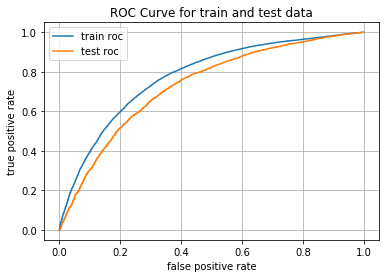

In [109]:
#ROC curves for train and test data sets

plt.plot(train_fpr,train_tpr, label = 'train roc')
plt.plot(test_fpr,test_tpr, label = 'test roc')
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for train and test data")
plt.grid()
plt.show()

In [110]:
print("The AUC value for train data is :",auc(train_fpr,train_tpr))
print("The AUC value for test data is :",auc(test_fpr,test_tpr))

The AUC value for train data is : 0.7773082792134446
The AUC value for test data is : 0.7303670825683239


<h4>Summary:</h4>
1. both train and test have AUC values grater than 0.5, model is performing better than random model

#### Confusion matrix on train data

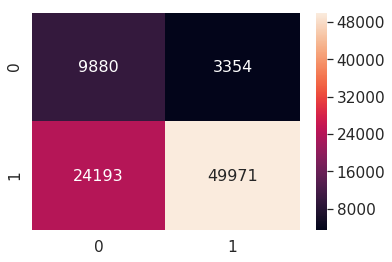

In [111]:
drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Train Data for BOW encoding</b></center>


 
 #### Confusion Matrix on test data

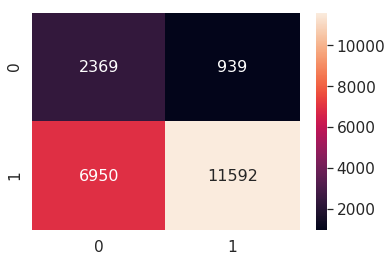

In [112]:
drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Test Data for BOW encoding</b></center>

### 5.1.2. categorical, numerical features + project_title(tf_idf) + preprocessed_essay (if_idf bigrams)

In [113]:
vectors_train = hstack((cat_num.tocsr(), train_tfidf_titles.tocsr(), train_tfidf_essays.tocsr()))
print(vectors_train.shape)
vectors_test = hstack((cat_num_test.tocsr(), test_tfidf_titles.tocsr(), test_tfidf_essays.tocsr()))
print(vectors_test.shape)

(87398, 19663)
(21850, 19663)


In [114]:
optimal_hyp = ApplyModel(vectors_train, project_data_labels_train, vectors_test, project_data_labels_test, hyperparams)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


**************************************************


applying gridsearch CV to find best hyper parameter
****grid search cv ended****
optimal hyper param is: 0.0001
best penalty is: l2


**************************************************




  0%|          | 0/21850 [00:00<?, ?it/s]

**************************************************
confusion matrix for training data
the maximum value of tpr*(1-fpr) 0.5493482407747655 for threshold 0.064
confusion matrix [[10126  3108]
 [21974 52190]]
Heat Map of Confusion of Matrix with training Data
**************************************************
confusion matrix for test data
the maximum value of tpr*(1-fpr) 0.45154140076380733 for threshold -0.02


100%|██████████| 21850/21850 [00:00<00:00, 1186549.74it/s]


confusion matrix [[ 2045  1263]
 [ 5329 13213]]
Heat Map of Confusion of Matrix with test Data
**************************************************


#### AUC vs hyper params

#### GridSearch CV selecting best hyperparams

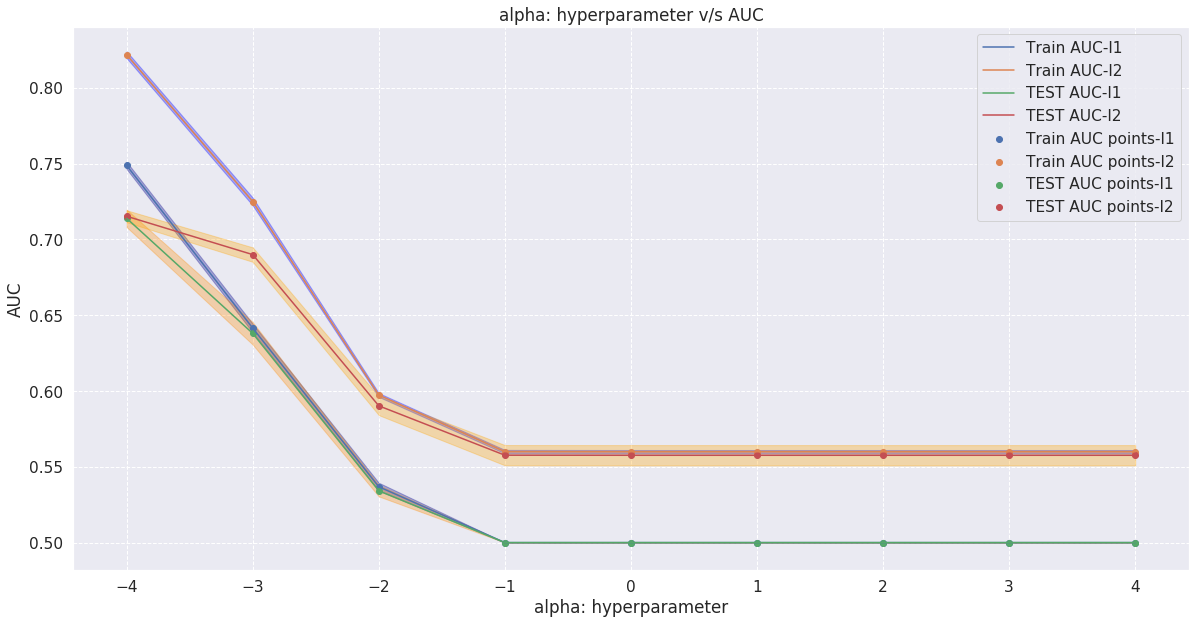

In [115]:
log_alphas = [math.log(x, 10) for x in hyperparams]
drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std)

In [116]:
print('the best params are', optimal_hyp)

the best params are {'penalty': 'l2', 'alpha': 0.0001}



#### ROC curve for Trian and Test data

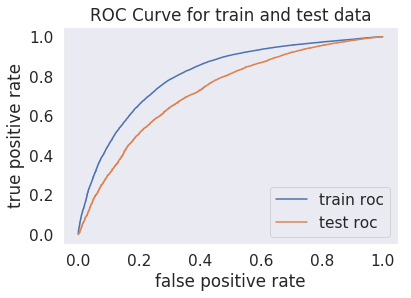

In [117]:
#ROC curves for train and test data sets
plt.plot(train_fpr,train_tpr, label = 'train roc')
plt.plot(test_fpr,test_tpr, label = 'test roc')
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for train and test data")
plt.grid()
plt.show()

#### Confusion matrix for Train Data

In [118]:
print("The AUC value for train data is :",auc(train_fpr,train_tpr))
print("The AUC value for test data is :",auc(test_fpr,test_tpr))

The AUC value for train data is : 0.807715503123805
The AUC value for test data is : 0.7258257732339288


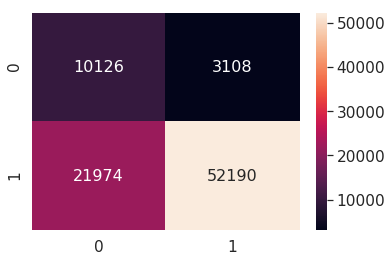

In [119]:
drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Train Data for TF_IDF encoding</b></center>


 
 #### Confusion Matrix on Test data

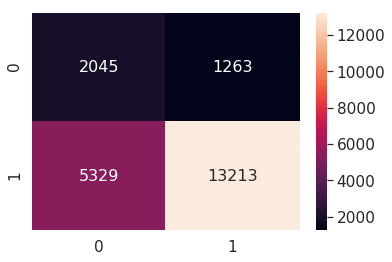

In [120]:
drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Test Data for TF_IDF encoding</b></center>

### 5.1.3. categorical, numerical features + project_title(avg_W2V) + preprocessed_essay (avg_W2V)

In [121]:
vectors_train = hstack((cat_num.tocsr(), avg_w2v_vectors_train, avg_w2v_vectors_titles_train)).tocsr()
print(vectors_train.shape)
vectors_test = hstack((cat_num_test.tocsr(), avg_w2v_vectors_test, avg_w2v_vectors_titles_test)).tocsr() 
print(vectors_test.shape)

(87398, 704)
(21850, 704)


In [122]:
optimal_hyp = ApplyModel(vectors_train, project_data_labels_train, vectors_test, project_data_labels_test, hyperparams)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


**************************************************


applying gridsearch CV to find best hyper parameter
****grid search cv ended****
optimal hyper param is: 0.0001
best penalty is: l2


**************************************************




100%|██████████| 21850/21850 [00:00<00:00, 1384896.75it/s]

**************************************************
confusion matrix for training data
the maximum value of tpr*(1-fpr) 0.44006626129673343 for threshold -0.228
confusion matrix [[ 9046  4188]
 [26754 47410]]
Heat Map of Confusion of Matrix with training Data
**************************************************
confusion matrix for test data
the maximum value of tpr*(1-fpr) 0.4299926556487921 for threshold -0.278


confusion matrix [[ 2186  1122]
 [ 6552 11990]]
Heat Map of Confusion of Matrix with test Data
**************************************************


#### AUC vs K-values Graph

#### Gridsearch CV Graph to find best hyperparameter

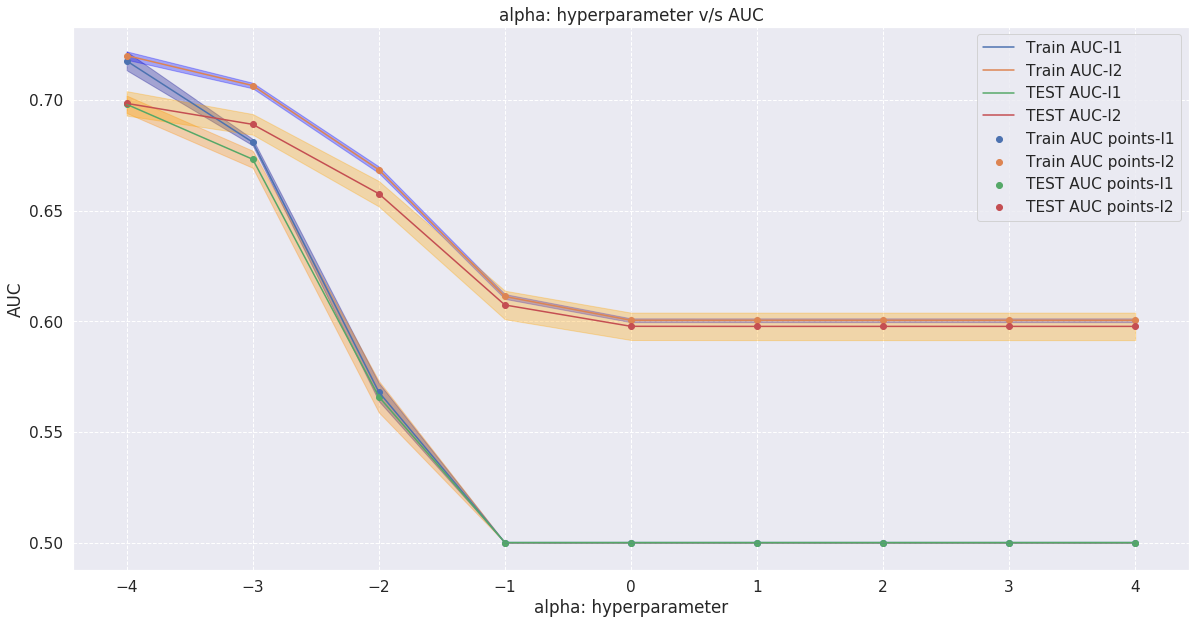

In [123]:
drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std)

In [124]:
print('the best params are', optimal_hyp)

the best params are {'penalty': 'l2', 'alpha': 0.0001}




#### ROC Curve

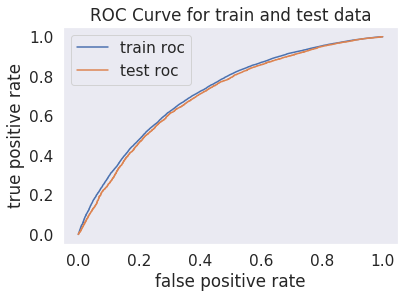

In [125]:
#ROC curves for train and test data sets
plt.plot(train_fpr,train_tpr, label = 'train roc')
plt.plot(test_fpr,test_tpr, label = 'test roc')
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for train and test data")
plt.grid()
plt.show()

In [126]:
print("The AUC value for train data is :",auc(train_fpr,train_tpr))
print("The AUC value for test data is :",auc(test_fpr,test_tpr))

The AUC value for train data is : 0.7184196054495208
The AUC value for test data is : 0.7047702382786125


#### Confusion Matrix for Train data

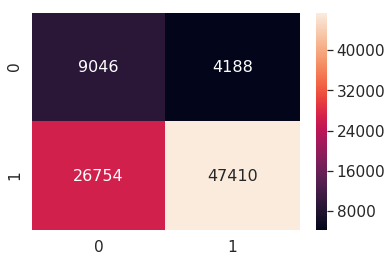

In [127]:
drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Train Data for average w2v encoding</b></center>


 #### Confusion Matrix for Test data

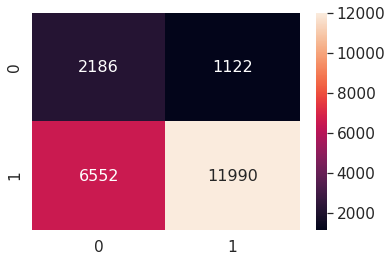

In [128]:
drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Test Data for avg W2V encoding</b></center>

### 5.1.4. categorical, numerical features + project_title(tf_IDF_avg_W2V) + preprocessed_essay (tf_IDF_avg_W2V)

In [129]:
vectors_train = hstack((cat_num.tocsr(), tfidf_w2v_vectors_train_essays,
               tfidf_w2v_vectors_train_titles)).tocsr()
print(vectors_train.shape)
vectors_test = hstack((cat_num_test.tocsr(), tfidf_w2v_vectors_test_essays, 
                    tfidf_w2v_vectors_test_titles)).tocsr() 
print(vectors_train.shape)

(87398, 704)
(87398, 704)


In [130]:
optimal_hyp = ApplyModel(vectors_train, project_data_labels_train, vectors_test, project_data_labels_test, hyperparams)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


**************************************************


applying gridsearch CV to find best hyper parameter
****grid search cv ended****
optimal hyper param is: 0.001
best penalty is: l2


**************************************************




100%|██████████| 21850/21850 [00:00<00:00, 1419540.62it/s]

**************************************************
confusion matrix for training data
the maximum value of tpr*(1-fpr) 0.43361026745418624 for threshold 0.141
confusion matrix [[ 8858  4376]
 [26353 47811]]
Heat Map of Confusion of Matrix with training Data
**************************************************
confusion matrix for test data
the maximum value of tpr*(1-fpr) 0.4234742341873745 for threshold 0.078


confusion matrix [[ 2101  1207]
 [ 6257 12285]]
Heat Map of Confusion of Matrix with test Data
**************************************************


#### Gridsearch CV Graph to find best hyperparameter

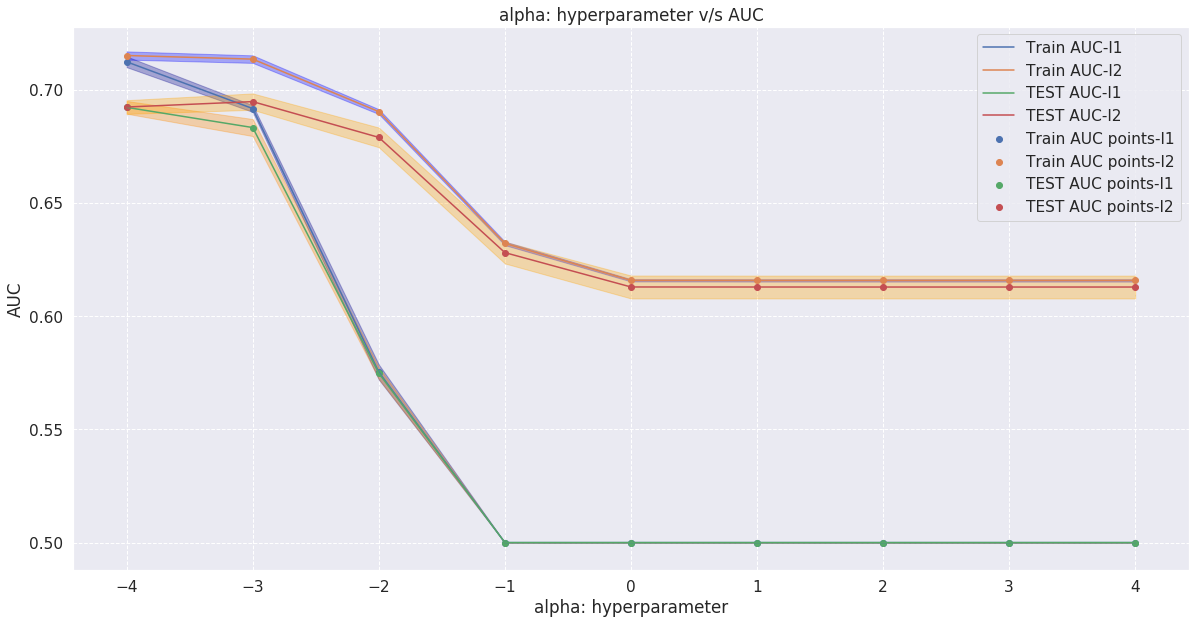

In [131]:
drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std)

In [132]:
print('the best params are', optimal_hyp)

the best params are {'penalty': 'l2', 'alpha': 0.001}



#### ROC curve for train and test data

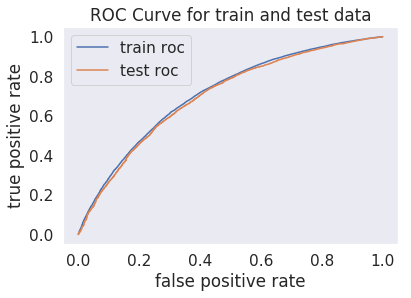

In [133]:
plt.plot(train_fpr,train_tpr, label = 'train roc')
plt.plot(test_fpr,test_tpr, label = 'test roc')
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for train and test data")
plt.grid()
plt.show()

In [134]:
print("The AUC value for train data is :",auc(train_fpr,train_tpr))
print("The AUC value for test data is :",auc(test_fpr,test_tpr))

The AUC value for train data is : 0.7109931905972784
The AUC value for test data is : 0.7006788862097709


#### Confusion Matrix for Train data

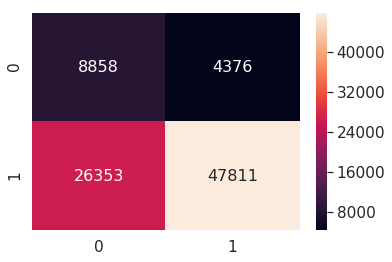

In [135]:
drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Train Data for TF_IDF W2V encoding</b></center>


 
 #### Confusion Matrix for Test Data

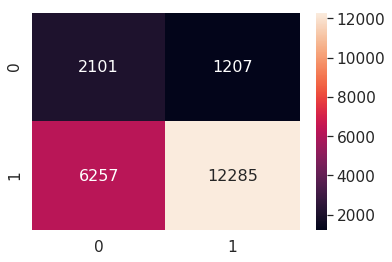

In [136]:
drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])

### Creating new feature essay sentiment analysers

In [137]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/kiranfet/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [138]:

neg_train = []
pos_train = []
neu_train = []
compound_train = []
for a in tqdm(project_data_train['preprocessed_essays']) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg_train.append(b)
    pos_train.append(c)
    neu_train.append(d)
    compound_train.append(e)
    
neg_test = []
pos_test = []
neu_test = []
compound_test = []
for a in tqdm(project_data_test['preprocessed_essays']) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg_test.append(b)
    pos_test.append(c)
    neu_test.append(d)
    compound_test.append(e)


100%|██████████| 21850/21850 [03:51<00:00, 94.19it/s] 


## Applying PCA on TF-IDF vectors of essays

In [139]:
#taking top 3000 dimensions
vectorizer = TfidfVectorizer(min_df=10, max_features=3000)
vectorizer.fit(project_data_train['preprocessed_essays'])
train_tfidf_essays_pca = vectorizer.transform(project_data_train['preprocessed_essays'])
print(train_tfidf_essays_pca.shape)
test_tfidf_essays_pca = vectorizer.transform(project_data_test['preprocessed_essays'])
print("Shape of matrix after TFIDF test data essays:",test_tfidf_essays_pca.shape)

(87398, 3000)
Shape of matrix after TFIDF test data essays: (21850, 3000)


In [140]:
from sklearn.decomposition import TruncatedSVD

#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
def ApplyPCA(components, data):
    pca = TruncatedSVD(n_components=components)
    pca.fit(data)
    return pca.explained_variance_ratio_.sum()

100%|██████████| 9/9 [27:15<00:00, 316.95s/it]


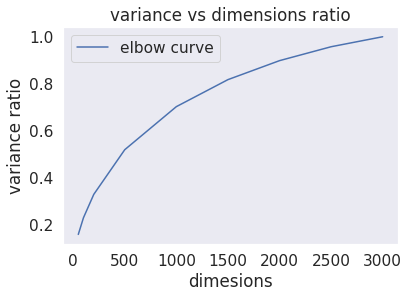

In [141]:
indexes = [50, 100, 200, 500, 1000, 1500, 2000, 2500, 2999]#apply for these random indexes
variances = []
for i in tqdm(indexes):
    variance = ApplyPCA(i, train_tfidf_essays_pca)
    variances.append(variance)


#elbow method to find best dimension

plt.plot(indexes,variances, label = 'elbow curve')
plt.legend()
plt.xlabel("dimesions")
plt.ylabel("variance ratio")
plt.title("variance vs dimensions ratio")
plt.grid()
plt.show()


In [142]:
print(variances[7])

0.9576064449305383


In [143]:
pca = TruncatedSVD(n_components=2500)
pca.fit(train_tfidf_essays_pca)

pca_train = pca.transform(train_tfidf_essays_pca)
print(pca_train.shape)
pca_test = pca.transform(test_tfidf_essays_pca)
print(pca_test.shape)

(87398, 2500)
(21850, 2500)


In [144]:
print(np.array(neu_train).reshape(-1,1))
vectorizer_train = hstack((cat_num.tocsr(), np.array(neg_train).reshape(-1,1),
                           np.array(pos_train).reshape(-1,1),
                           np.array(neu_train).reshape(-1,1), np.array(compound_train).reshape(-1,1), pca_train)).tocsr()

vectorizer_test = hstack((cat_num_test.tocsr(), np.array(neg_test).reshape(-1,1),
                          np.array(pos_test).reshape(-1,1),
                           np.array(neu_test).reshape(-1,1), np.array(compound_test).reshape(-1,1), pca_test)).tocsr()

[[0.716]
 [0.615]
 [0.621]
 ...
 [0.68 ]
 [0.626]
 [0.746]]


we are now using sentiment analysis data and PCA dimensional reduced data of essay and no text data to understand the impact of text data

In [145]:
print(len(pca_test[:1][0]))

2500


In [146]:
optimal_hyp = ApplyModel(vectorizer_train, project_data_labels_train, vectorizer_test, project_data_labels_test, hyperparams)

[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


**************************************************


applying gridsearch CV to find best hyper parameter
****grid search cv ended****
optimal hyper param is: 0.0001
best penalty is: l2


**************************************************




  0%|          | 0/21850 [00:00<?, ?it/s]

**************************************************
confusion matrix for training data
the maximum value of tpr*(1-fpr) 0.4895316223930958 for threshold -0.152
confusion matrix [[ 9616  3618]
 [25063 49101]]
Heat Map of Confusion of Matrix with training Data
**************************************************
confusion matrix for test data
the maximum value of tpr*(1-fpr) 0.4546801620478727 for threshold -0.097


100%|██████████| 21850/21850 [00:00<00:00, 1193938.72it/s]

confusion matrix [[ 2351   957]
 [ 6929 11613]]
Heat Map of Confusion of Matrix with test Data
**************************************************


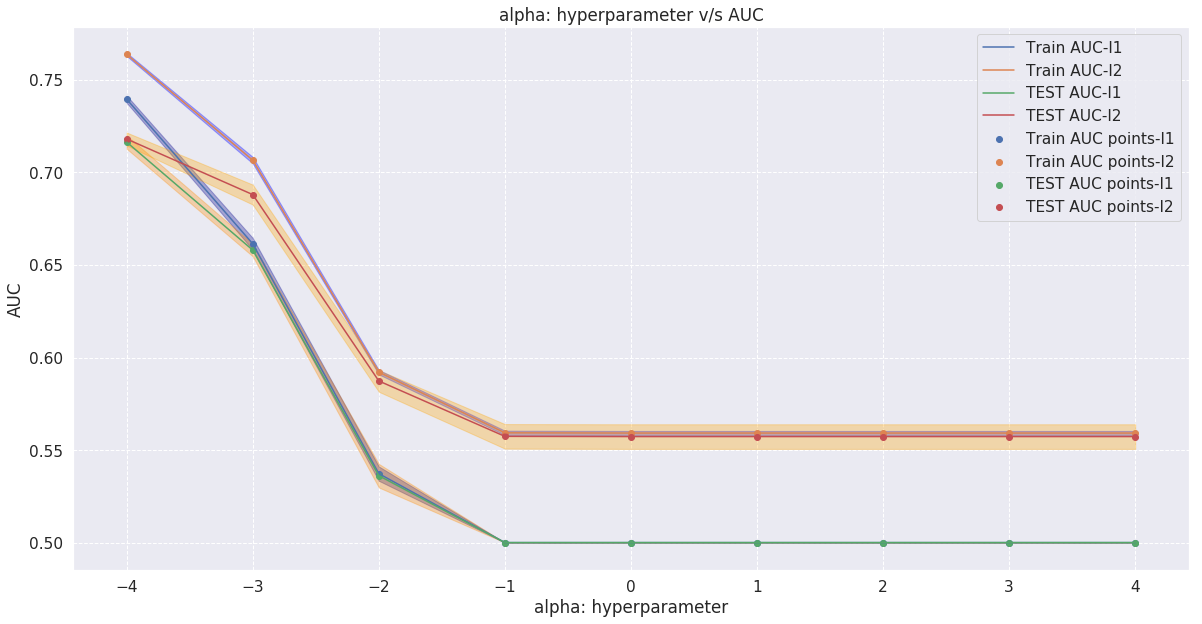

In [147]:
import math
import matplotlib.pyplot as plt
log_alphas = [math.log(x, 10) for x in hyperparams]
drawGridSearchCurve(log_alphas, train_auc, train_auc_std, test_auc, test_auc_std)

In [153]:
print('optimal hyperparameter and best penalty are', optimal_hyp)

optimal hyperparameter and best penalty are {'penalty': 'l2', 'alpha': 0.0001}


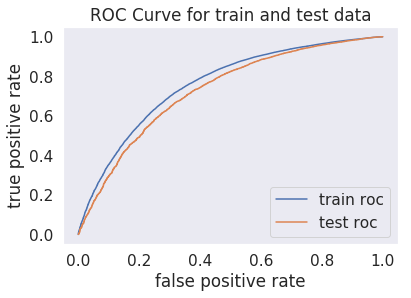

In [148]:
#ROC curves for train and test data sets
plt.plot(train_fpr,train_tpr, label = 'train roc')
plt.plot(test_fpr,test_tpr, label = 'test roc')
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve for train and test data")
plt.grid()
plt.show()

In [149]:
print("The AUC value for train data is :",auc(train_fpr,train_tpr))
print("The AUC value for test data is :",auc(test_fpr,test_tpr))

The AUC value for train data is : 0.7589677378262457
The AUC value for test data is : 0.7281023297283711


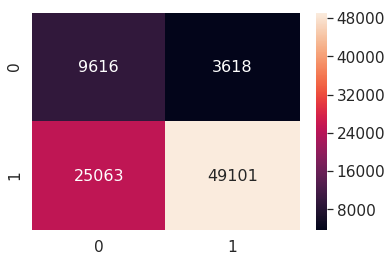

In [150]:
drawHeatMap(cnf_matrix_train, ['0','1'], ['0','1'])

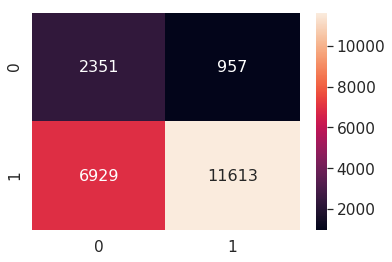

In [151]:
drawHeatMap(cnf_matrix_test, ['0','1'], ['0','1'])

<center><b>Confustion Matrix of Test Data for TF_IDF w2v encoding</b></center>

# Conclusions

In [154]:
# Compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

#AUC: area under curve for Test data

x = PrettyTable()
x.field_names = ["Vectorizer","Hyper Parameter","Penalty", "AUC"]

x.add_row(['BOW', 0.01,'l2', 0.7303])
x.add_row(['tf_idf', 0.0001, 'l2', 0.7258])
x.add_row(['avg w2v', 0.0001, 'l2', 0.7047])
x.add_row(['tf_idf_word to vec', 0.001, 'l2', 0.7006])
x.add_row(['SVD + numerical + categorical', 0.0001, 'l2', 0.7281])

print(x)

+-------------------------------+-----------------+---------+--------+
|           Vectorizer          | Hyper Parameter | Penalty |  AUC   |
+-------------------------------+-----------------+---------+--------+
|              BOW              |       0.01      |    l2   | 0.7303 |
|             tf_idf            |      0.0001     |    l2   | 0.7258 |
|            avg w2v            |      0.0001     |    l2   | 0.7047 |
|       tf_idf_word to vec      |      0.001      |    l2   | 0.7006 |
| SVD + numerical + categorical |      0.0001     |    l2   | 0.7281 |
+-------------------------------+-----------------+---------+--------+


**The hyper parameter penalty and AUC values for tf_idf vectorized essays and titles are very close to PCA applied and sentiment analysied data of essays, which means titles has very little impact on outcome of the model when tf_idf vectorization is considered**